## Fundamental extraction example

Use maelzel.snd.audiosample.Sample to load and manipulate an audio soundfile. A Sample can play itself (using csoundengine), has a nice html representation in jupyter with a waveform and browser playback.

In [1]:
from maelzel.snd import audiosample
import numpy as np
from emlib import numpytools

In [2]:
s = audiosample.Sample("istambul2.flac")

Sample: dur=20.000000 sr=44100 ch=2
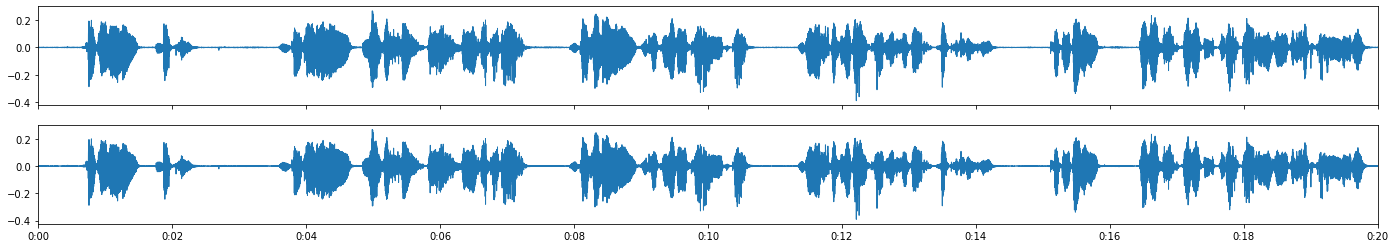

In [3]:
s

Extract the fundamental of `s` and plot it against the spectrogram

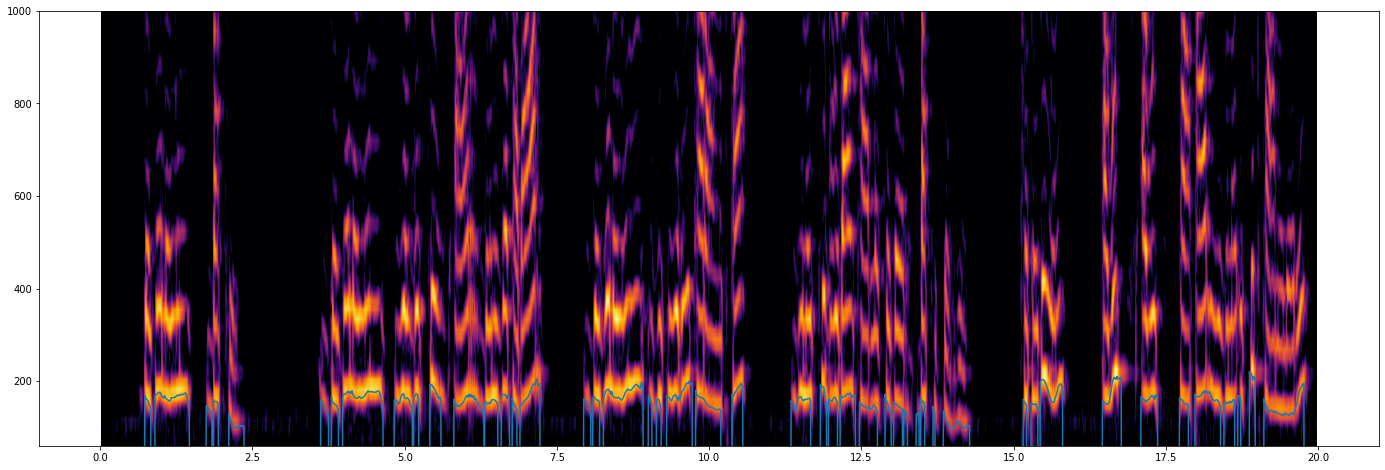

Sampled[0.0:19.998187105]

In [34]:
f0 = s.fundamentalBpf(fftsize=2048, overlap=8, method='pyin')
axes = s.plotSpectrogram(maxfreq=1000, minfreq=60, fftsize=2048, overlap=4, mindb=-80)
f0.plot(n=2000, axes=axes)

In [35]:
amp = f0 > 70

Get the csound Engine used by `audiosample`, since sample playback needs to be choordinated with the fundamental playback

In [36]:
e = audiosample.getPlayEngine()
e

Engine(name=engine0, sr=48000, backend=jack, outdev=dac:Built-in Audio Pro:, nchnls=4, indev=adc:Built-in Audio Pro:, nchnls_i=2, bufferSize=512)

Create an instr to play back the extracted fundamental as a square wave

In [37]:
e.compile(r'''
instr 10
  kfreq = p4
  kamp = p5
  igain = p6
  asig vco2 1, kfreq
  asig *= a(lag:k(kamp*igain, 0.01))
  outch 1, asig
endin
''')

In [38]:
xs, freqs = f0.points()
freqpairs = numpytools.interlace(xs, freqs)
amppairs = numpytools.interlace(xs, amp.map(xs))

In [43]:
f0synth = e.sched(10, 0, s.duration+0.1, args=[200, 0.0, 0.1])
with e.lockedElapsedTime():
    s.play(delay=2048/e.sr)
    e.automatep(f0synth, 4, freqpairs)
    e.automatep(f0synth, 5, amppairs)